# Activation steering to turn right

In [1]:
%env

{'COMMAND_MODE': 'unix2003',
 'HOME': '/Users/benjamin.berczi',
 'HOMEBREW_CELLAR': '/opt/homebrew/Cellar',
 'HOMEBREW_PREFIX': '/opt/homebrew',
 'HOMEBREW_REPOSITORY': '/opt/homebrew',
 'INFOPATH': '/opt/homebrew/share/info:',
 'LOGNAME': 'benjamin.berczi',
 'LaunchInstanceID': '74E4E318-53B5-4B19-8242-DEFF82A98823',
 'MANPATH': '/opt/homebrew/share/man::',
 'MallocNanoZone': '0',
 'OLDPWD': '/',
 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
 'PATH': '/opt/homebrew/bin:/Users/benjamin.berczi/Library/Python/3.11/bin:/Users/benjamin.berczi/.rd/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Users/benjamin.berczi/.rd/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bi

In [2]:
import os 
PYTORCH_ENABLE_MPS_FALLBACK=1
CUDA_VISIBLE_DEVICES=""
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"




In [3]:
import sys
sys.path

sys.path.append("/Users/benjamin.berczi/Documents/maze-dataset")
sys.path.append("/Users/benjamin.berczi/Documents/maze-transformer-1")
sys.path.append("/Users/benjamin.berczi/Documents/research")
sys.path.append("/Users/benjamin.berczi/Documents/research/unsearch_research")


In [4]:
# Imports
%load_ext autoreload
%autoreload 2

# General Utilities
from pathlib import Path

# Generic ML
import numpy as np
import torch
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('medium') # if your GPU has TensorCores

# Maze Transformer and Dataset

# Other useful things
from muutils.nbutils.configure_notebook import configure_notebook
from unsearch_research import *

# other package imports
import matplotlib.pyplot as plt # keep this import for CI to work
from zanj import ZANJ # saving/loading data
from muutils.mlutils import pprint_summary # pretty printing as json

# maze_dataset imports

from maze_dataset import LatticeMaze, SolvedMaze, MazeDataset, MazeDatasetConfig
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.generation import LatticeMazeGenerators, GENERATORS_MAP
from maze_dataset.generation.default_generators import DEFAULT_GENERATORS
from maze_dataset.dataset.configs import MAZE_DATASET_CONFIGS
from maze_dataset.plotting import plot_dataset_mazes, print_dataset_mazes

from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data


# check the configs
print(MAZE_DATASET_CONFIGS.keys())
# for saving/loading things
zanj: ZANJ = ZANJ(external_list_threshold=256)

/opt/homebrew/Cellar/python@3.11/3.11.7/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


dict_keys(['test-g3-n5-a_dfs-h75556', 'demo_small-g3-n100-a_dfs-h88371', 'demo-g6-n10K-a_dfs-h30615'])


In [5]:
# Configuration
SEED = 42
DARK_MODE = True
LOCAL_DATA_PATH = Path("/Users/benjamin.berczi/Documents")
#LOCAL_DATA_PATH: str = "../data/maze_dataset"

DEVICE = configure_notebook(
    seed=SEED,
    dark_mode=DARK_MODE,
    device=None,  # Defaults GPU > MPS > CPU
)
set_unsearch_style(dark_mode=DARK_MODE) # Matplotlib style

set up plots with PLOT_MODE = 'inline', FIG_OUTPUT_FMT = None, FIG_BASEPATH = None


In [6]:
#model_run_id = "mixed_maze_sweep02_10-seed_1-lr_0.001-h_8-l_12-d_512-posembed_standard-20240210223618"
#model_run_id = "mixed_maze_sweep02_12-seed_2-lr_0.0001-h_8-l_8-d_512-posembed_standard-20240212110545"
model_run_id = "mixed_maze_sweep02_10-seed_1-lr_0.0001-h_8-l_6-d_512-posembed_standard-20240210223546"

model, cfg = load_wandb_model(
    entity="aisc-search",
    project="mixed_maze_sweep",
    run_id=model_run_id,
    # The following may be required for some older models with incomplete cfgs on wandb
    # you'll know because loading will complain about mismatched position embedding weights
    # config_overrides={"model_cfg": {"positional_embedding_type": "rotary"}},
    output_path=LOCAL_DATA_PATH / "downloaded_models",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


No wandb context found, creating one...


wandb: Currently logged in as: benji-berczi (aisc-search). Use `wandb login --relogin` to force relogin
wandb: WARNING Tried to auto resume run with id mixed_maze_sweep02_12-seed_2-lr_0.0001-h_8-l_8-d_512-posembed_standard-20240212110545 but id mixed_maze_sweep02_10-seed_1-lr_0.0001-h_8-l_6-d_512-posembed_standard-20240210223546 is set.


Loading latest checkpoint
Model already downloaded to /Users/benjamin.berczi/Documents/downloaded_models/mixed_maze_sweep02_10-seed_1-lr_0.0001-h_8-l_6-d_512-posembed_standard-20240210223546


In [7]:
# Load a dataset
tokenizer: MazeTokenizer = MazeTokenizer(tokenization_mode=TokenizationMode.AOTP_UT_rasterized, max_grid_size=7)



cfg = MazeDatasetConfig(
    name="test",  
    grid_n=5,  
    n_mazes=10,  
    maze_ctor=LatticeMazeGenerators.gen_dfs,  
    #maze_ctor_kwargs=dict(do_forks=False),

)

dataset = MazeDataset.from_config(
	cfg,
	load_local=True,
	do_generate=True,
    save_local=True,
	local_base_path=LOCAL_DATA_PATH / 'mazes',
	verbose=False,
)

(<Figure size 1000x200 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

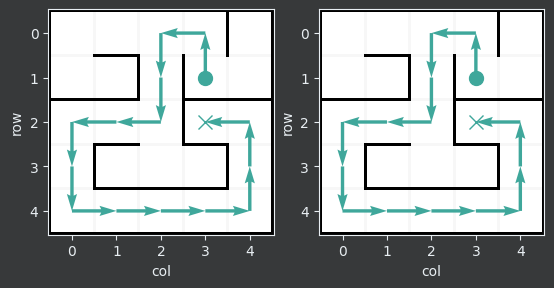

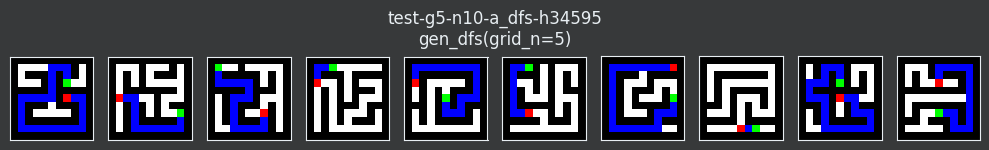

In [8]:
# Plot a maze
# gridspec
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2)

# Test plotting function on the LattizeMaze
plot_maze(dataset[0], tokenizer=tokenizer, ax=gs[0, 0])

# Get LatticeMaze object from string and plot that directly too!
ds_string = dataset[0].as_tokens(tokenizer)
plot_maze(ds_string, tokenizer=tokenizer, ax=gs[0,1])

# note that the vocab is 7x7 so the second plot shows the maze as a 7x7 grid
plot_dataset_mazes(dataset, count=None) # for large datasets, set the count to some int to just plot the first few

# Experiment 1 - Stuff
We'll use a hook with function closure to intervene and cache (more efficiently than caching everything when using ```run_with_cache```). We also have a modified version of the `generation` function from TransformerLens which we can use to apply hooks during a generative rollout

In [9]:
# Let's look at what the model contains
from arrgh import arrgh

model.eval()
with torch.device('cpu'):
    inp = '<PATH_START>'
    next_token, cache = model.run_with_cache(inp, prepend_bos=False)
    
arrgh(**cache)

                          name | dtype         | shape         | type         | device | min         | max       | mean        
-------------------------------------------------------------------------------------------------------------------------------
                    hook_embed | torch.float32 | [1, 1, 512]   | torch.Tensor | mps:0  | -0.12058    | 0.106894  | -2.32831e-10
                hook_pos_embed | torch.float32 | [1, 1, 512]   | torch.Tensor | mps:0  | -0.0728284  | 0.120151  | -2.32831e-10
       blocks.0.hook_resid_pre | torch.float32 | [1, 1, 512]   | torch.Tensor | mps:0  | -0.112274   | 0.142576  | -3.49246e-10
       blocks.0.ln1.hook_scale | torch.float32 | [1, 1, 1]     | torch.Tensor | mps:0  | 0.0386244   | 0.0386244 | 0.0386244   
  blocks.0.ln1.hook_normalized | torch.float32 | [1, 1, 512]   | torch.Tensor | mps:0  | -2.90681    | 3.69134   | -7.45058e-09
          blocks.0.attn.hook_q | torch.float32 | [1, 1, 8, 64] | torch.Tensor | mps:0  | -2.65223    | 2

In [10]:
inp

'<PATH_START>'

In [11]:
from unsearch_research.stable.analysis import intervene_upon_generation


def patching_hook(model_in, token_to_patch, layer_to_patch):
    # Model in is list of str tokens (could batch tensor and use gather)
    def layer_output_patch_hook(inp, hook):
        # inp has shape [batch_size, seq_len, hidden_dim]
        # Match token to patch
        matched_pos = model_in.index(token_to_patch)

        # patch inp at matched_pos
        inp[:,matched_pos] += 5 * torch.randn_like(inp[:, 0, :])# 10 * torch.randn_like(inp[:, 0, :])
        print(inp)
        return inp

    return [(f"blocks.{layer_to_patch}.hook_resid_post", layer_output_patch_hook)]


In [12]:
# Prepare example and hook
example = dataset[0].as_tokens(tokenizer)
prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

start_pos_random_patch_hook = patching_hook(prompt, "<PATH_START>", 2)

In [13]:
# Run intervention - generate with hook applied to same layer
#                    and token at each step of the rollout

prediction_original = model.generate(
    " ".join(prompt),
    prepend_bos=False,
    max_new_tokens=40,
    do_sample=False
)

prediction_perturbed = intervene_upon_generation(
    model,
    " ".join(prompt),
    start_pos_random_patch_hook,
    do_sample=False,
    max_new_tokens=40,
    device=DEVICE,
)
prediction_perturbed = model.to_string(prediction_perturbed)[0]

  0%|          | 0/40 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/transformer_lens/HookedTransformer.py:1660: UserWarning:

The operator 'aten::isin.Tensor_Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)



  0%|          | 0/40 [00:00<?, ?it/s]

tensor([[[-0.1365, -0.2067, -0.1164,  ...,  0.3214,  0.4002, -0.0749],
         [-0.1092, -0.1492, -0.1272,  ...,  0.3306,  0.1735, -0.0717],
         [-0.7632,  0.2992,  0.8594,  ...,  0.2720,  0.5603,  1.1381],
         ...,
         [-0.0271,  1.2409, -0.6756,  ...,  1.1997, -0.4642, -0.1710],
         [ 0.2418, -1.1416, -0.5995,  ..., -1.0302,  0.1248,  0.2211],
         [ 4.3837,  0.9163,  1.1898,  ...,  0.7511, 10.3909, -3.6039]]],
       device='mps:0', grad_fn=<CopySlices>)
tensor([[[-0.1365, -0.2067, -0.1164,  ...,  0.3214,  0.4002, -0.0749],
         [-0.1092, -0.1492, -0.1272,  ...,  0.3306,  0.1735, -0.0717],
         [-0.7632,  0.2992,  0.8594,  ...,  0.2720,  0.5603,  1.1381],
         ...,
         [ 0.2418, -1.1416, -0.5995,  ..., -1.0302,  0.1248,  0.2211],
         [-7.6679, -2.4388,  0.6540,  ..., -7.4529,  1.9220, -0.1323],
         [-0.3428, -0.2805, -0.1669,  ..., -1.4082, -0.3464, -0.2916]]],
       device='mps:0', grad_fn=<CopySlices>)
tensor([[[-0.1365, -0.2067

In [14]:
# Look at the output
from unsearch_research.stable.utils import get_aligned_lists

get_aligned_lists(
    prediction_original.split(" ")[len(prompt)-1:],
    prediction_perturbed.split(" ")[len(prompt)-1:],
    titles=["Original", "Perturbed"],
    use_rich=True,
)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃   Original   ┃  Perturbed   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ <PATH_START> │ <PATH_START> │
│    (1,3)     │    (3,6)     │
│    (0,3)     │    (4,6)     │
│    (0,2)     │    (3,4)     │
│    (1,2)     │    (2,4)     │
│    (2,2)     │    (2,3)     │
│    (2,1)     │  <PATH_END>  │
│    (2,0)     │              │
│    (3,0)     │              │
│    (4,0)     │              │
│    (4,1)     │              │
│    (4,2)     │              │
│    (4,3)     │              │
│    (4,4)     │              │
│    (3,4)     │              │
│    (2,4)     │              │
│    (2,3)     │              │
│  <PATH_END>  │              │
└──────────────┴──────────────┘

GridSpec(1, 2)[0:1, 1:2]

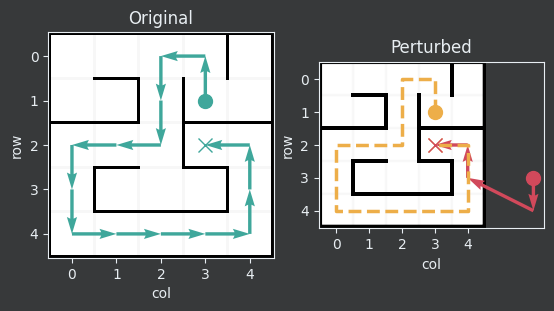

In [15]:
# Plot the output
gs = GridSpec(1, 2)
plot_maze(prediction_original, tokenizer=tokenizer, ax=gs[0, 0], ax_labels={'maze':{'title': 'Original'}})
plot_maze(prediction_perturbed, tokenizer=tokenizer, ax=gs[0, 1], ax_labels={'maze':{'title': 'Perturbed'}})

## Creating data set (start with right/left turn)

In [16]:
maze: SolvedMaze = dataset[0]

print(maze.as_ascii())

print(maze.generation_meta)

lattice_maze: LatticeMaze = LatticeMaze(
	connection_list=maze.connection_list,
	generation_meta=maze.generation_meta,
)

###########
#    XXX# #
# ###X#X# #
#   #X#S  #
#####X#####
#XXXXX#EXX#
#X### ###X#
#X#     #X#
#X#######X#
#XXXXXXXXX#
###########
{'func_name': 'gen_dfs', 'grid_shape': array([5, 5]), 'start_coord': array([2, 3]), 'n_accessible_cells': 25, 'max_tree_depth': 50, 'fully_connected': True, 'visited_cells': [[4, 0], [3, 4], [4, 3], [3, 1], [0, 2], [2, 2], [1, 0], [1, 3], [4, 2], [3, 0], [3, 3], [0, 1], [2, 4], [1, 2], [0, 4], [2, 1], [3, 2], [4, 1], [4, 4], [0, 0], [1, 1], [0, 3], [2, 0], [1, 4], [2, 3]]}


(<Figure size 10000x200 with 100 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        

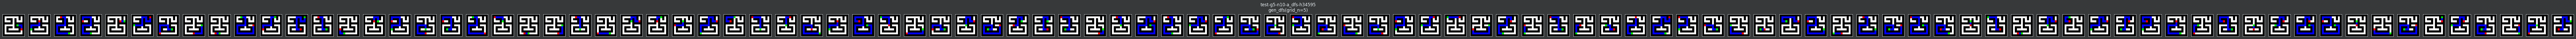

In [17]:
variants: list[SolvedMaze] = [
	SolvedMaze(
		connection_list=lattice_maze.connection_list,
		generation_meta=lattice_maze.generation_meta,
		solution=lattice_maze.generate_random_path(),
	)
	for _ in range(100)
]
variants_dataset = MazeDataset(
	cfg=dataset.cfg,
	mazes=variants,
)
plot_dataset_mazes(variants_dataset)

(<Figure size 7600x200 with 76 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

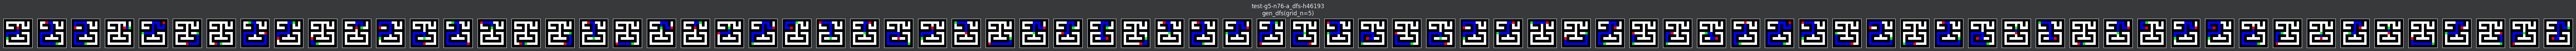

In [18]:
dataset_filtered: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : len(m.get_coord_neighbors(m.start_pos)) > 1
)

plot_dataset_mazes(dataset_filtered)

In [19]:
variants_dataset.custom_maze_filter(lambda m : m.get_solution_tokens()[1][1] < m.get_solution_tokens()[2][1])

## Creating data set that always starts with a right turn

(<Figure size 3400x200 with 34 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

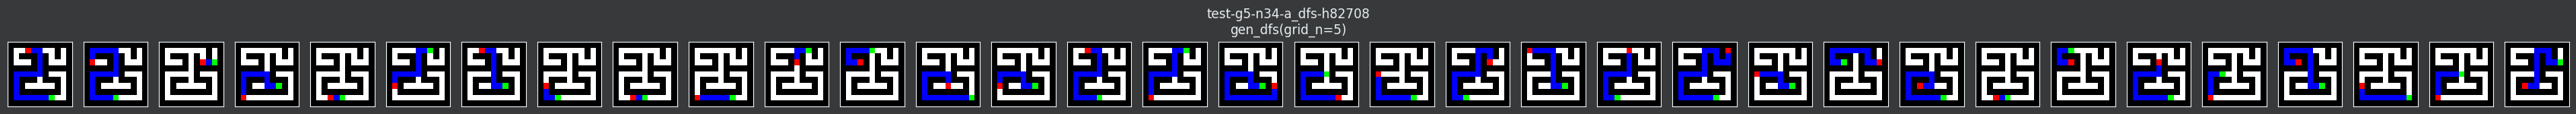

In [20]:
dataset_right: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : m.get_solution_tokens()[1][1] < m.get_solution_tokens()[2][1]
)

dataset_left: MazeDataset = variants_dataset.custom_maze_filter(
	lambda m : m.get_solution_tokens()[1][1] > m.get_solution_tokens()[2][1]
)

plot_dataset_mazes(dataset_left)

Now I need to somehow get the activations of the first step!



In [21]:
# Prepare example and hook
example = dataset_right[1].as_tokens(tokenizer)
prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

prediction_original = model.generate(
    " ".join(prompt),
    prepend_bos=False,
    max_new_tokens=40,
    do_sample=False
)

  0%|          | 0/40 [00:00<?, ?it/s]

GridSpec(1, 2)[0:1, 0:1]

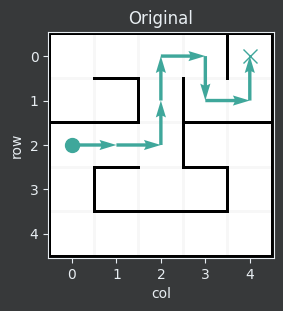

In [22]:
plot_maze(prediction_original, tokenizer=tokenizer, ax=gs[0, 0], ax_labels={'maze':{'title': 'Original'}})


In [23]:
preds=[]
for i in range(len(dataset_left)):
    # Prepare example and hook
    example = dataset_left[i].as_tokens(tokenizer) 
    prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

    prediction_original = model.generate(
        " ".join(prompt),
        prepend_bos=False,
        max_new_tokens=40,
        do_sample=False
    )
    preds.append(prediction_original)



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

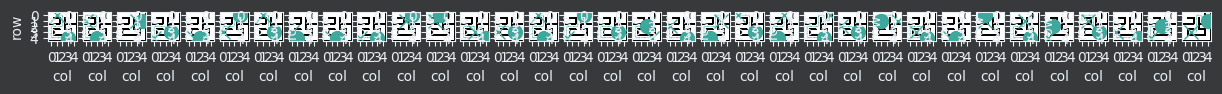

In [24]:
plt.figure(figsize=(15,5))
gs = GridSpec(1, len(dataset_left))
for i in range(len(dataset_left)):
    plot_maze(preds[i], tokenizer=tokenizer, ax=gs[0, i])

In [37]:
layer = 5
coeff = 5

In [38]:
example = dataset_right[0].as_tokens(tokenizer) 
prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

name = f"blocks.{layer}.hook_resid_pre"
cache, caching_hooks, _ = model.get_caching_hooks(lambda n: n == name)
with model.hooks(fwd_hooks=caching_hooks):
    _ = model(" ".join(prompt))
c = cache[name]

In [39]:
cache_n_r=torch.zeros_like(c)
for i in range(len(dataset_right)):
    # Prepare example and hook
    example = dataset_right[i].as_tokens(tokenizer) 
    prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

    name = f"blocks.{layer}.hook_resid_pre"
    cache, caching_hooks, _ = model.get_caching_hooks(lambda n: n == name)
    with model.hooks(fwd_hooks=caching_hooks):
        _ = model(" ".join(prompt))
    cache_n_r+= cache[name]/len(dataset_right)

TO DO
put the mazes into a batch and can just run the batch in the model!!
make sure they are padded (they are the same lenght)

In [40]:
cache_n_l=torch.zeros_like(c)

for i in range(len(dataset_left)):
    # Prepare example and hook
    example = dataset_left[i].as_tokens(tokenizer) 
    prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

    name = f"blocks.{layer}.hook_resid_pre"
    cache, caching_hooks, _ = model.get_caching_hooks(lambda n: True)
    with model.hooks(fwd_hooks=caching_hooks):
        _ = model(" ".join(prompt))
    cache_n_l += cache[name]/len(dataset_left)

In [41]:
cache_n_r.shape

torch.Size([1, 106, 512])

In [42]:
len(prompt)

105

In [43]:
act_diff = cache_n_r-cache_n_l

In [44]:
import re
import pprint
from collections import defaultdict

def construct_activation_summary(cache, shapes_as_str: bool = False):
    def recursive_insert(tree, keys, value):
        if len(keys) == 1:
            tree[keys[0]] = value
        else:
            if keys[0] not in tree:
                tree[keys[0]] = {}
            recursive_insert(tree[keys[0]], keys[1:], value)

    def shape_conversion(value):
        if shapes_as_str:
            return str(tuple(value.shape))
        else:
            return tuple(value.shape)

    activation_summary = {}
    pattern = re.compile(r'^blocks\.(\d+)\.(.*)$')
    block_keys = defaultdict(lambda: defaultdict(lambda: []))

    # First pass to collect keys and block numbers
    for key, value in cache.items():
        match = pattern.match(key)
        if match:
            block_num, sub_key = match.groups()
            block_keys[sub_key][shape_conversion(value)].append(int(block_num))

    # Second pass to insert with aggregated ranges
    for sub_key, shapes in block_keys.items():
        for shape, blocks in shapes.items():
            blocks.sort()
            # Check if the sequence of blocks is continuous
            if blocks[-1] - blocks[0] == len(blocks) - 1:
                new_key = f"blocks.[{blocks[0]}-{blocks[-1]}].{sub_key}"
            else:
                new_key = ', '.join([f"blocks.[{b}]" for b in blocks]) + f".{sub_key}"
            keys_hierarchy = new_key.split('.')
            recursive_insert(activation_summary, keys_hierarchy, shape)

    # Insert non-block keys directly
    for key, value in cache.items():
        if not pattern.match(key):
            activation_summary[key] = shape_conversion(value)

    return activation_summary

# Assuming `cache` is your ActivationCache object
activation_summary = construct_activation_summary(cache, shapes_as_str=True)
import json
import yaml
print(yaml.dump(activation_summary, default_flow_style=False))

blocks:
  '[0-11]':
    attn:
      hook_q: (1, 106, 8, 64)
      hook_v: (1, 106, 8, 64)
      hook_z: (1, 106, 8, 64)
    hook_attn_out: (1, 106, 512)
    hook_mlp_out: (1, 106, 512)
    hook_resid_mid: (1, 106, 512)
    hook_resid_post: (1, 106, 512)
    hook_resid_pre: (1, 106, 512)
    ln1:
      hook_normalized: (1, 106, 512)
      hook_scale: (1, 106, 1)
    ln2:
      hook_normalized: (1, 106, 512)
      hook_scale: (1, 106, 1)
    mlp:
      hook_post: (1, 106, 2048)
      hook_pre: (1, 106, 2048)
hook_embed: (1, 106, 512)
hook_pos_embed: (1, 106, 512)
ln_final.hook_normalized: (1, 106, 512)
ln_final.hook_scale: (1, 106, 1)



In [45]:
#print(model)

In [101]:
def patching_hook_right(model_in, token_to_patch, layer_to_patch, coeff, act_diff):
    # Model in is list of str tokens (could batch tensor and use gather)
    def layer_output_patch_hook(inp, hook):
        # inp has shape [batch_size, seq_len, hidden_dim]

        if inp.shape[1] == 1:
            return  
        
        ppos, apos = inp.shape[1], act_diff.shape[1]

        if apos <= ppos:
            inp[:, :apos, :] += coeff * act_diff
        else:
            inp += coeff * act_diff[:,apos-ppos:]
        
        return inp

    return [(f"blocks.{layer_to_patch}.hook_resid_post", layer_output_patch_hook)]

# def patching_hook_right2(model_in, token_to_patch, layer_to_patch, act_diff):
#     # Model in is list of str tokens (could batch tensor and use gather)
#     def layer_output_patch_hook(inp, hook):
#         # inp has shape [batch_size, seq_len, hidden_dim]

#         matched_pos = model_in.index(token_to_patch)

#         # patch inp at matched_pos
#         inp[:,matched_pos] += 20 * act_diff[:,matched_pos,:] 
        
#         return inp

#     return [(f"blocks.{layer_to_patch}.hook_resid_post", layer_output_patch_hook)]

# def patching_hook_rand(model_in, token_to_patch, new_start_pos, layer_to_patch, act_diff):
#     # Model in is list of str tokens (could batch tensor and use gather)
#     def layer_output_patch_hook(inp, hook):
#         # inp has shape [batch_size, seq_len, hidden_dim]

#         if inp.shape[1] == 1:
#             return  
        
#         ppos, apos = inp.shape[1], act_diff.shape[1]

#         if apos <= ppos:
#             inp[:, :apos, :] += coeff * act_diff
#         else:
#             inp += coeff * act_diff[:,apos-ppos:]
        
#         matched_pos = model_in.index(token_to_patch)

#         # patch inp at matched_pos
#         inp[:,matched_pos] += 5 * inp[:, model_in.new_start_pos, :]# 10 * torch.randn_like(inp[:, 0, :])
        
#         return inp

#     return [(f"blocks.{layer_to_patch}.hook_resid_post", layer_output_patch_hook)]

## Questions:
 - Shape of act_diff needs to somehow match the inp shape? Or I shouldn't add act_diff to inp, but something else?
 - Also why is the shape of the act_diff (105,2,512) ?
 - Which token do I add act_diff to here? Is it PATH_START, or the one after it?
 - Which layer should I add it to? 
 - How can I patch to not the very first token?

In [102]:
# Prepare example and hook
example = dataset_left[21].as_tokens(tokenizer)
prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

turn_right_patch_hook = patching_hook_right(prompt, example[example.index("<PATH_START>") + 1], layer, coeff, act_diff)


# Run intervention - generate with hook applied to same layer
#                    and token at each step of the rollout

prediction_original = model.generate(
    " ".join(prompt),
    prepend_bos=False,
    max_new_tokens=40,
    do_sample=False
)

prediction_perturbed = intervene_upon_generation(
    model,
    " ".join(prompt),
    turn_right_patch_hook,
    do_sample=False,
    max_new_tokens=40,
    device=DEVICE,
)
prediction_perturbed = model.to_string(prediction_perturbed)[0]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Layer = 5


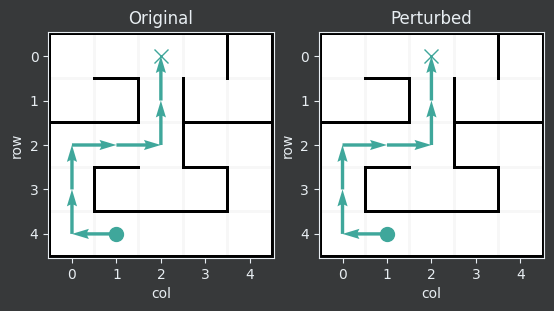

In [104]:

# Plot the output
gs = GridSpec(1, 2)
plot_maze(prediction_original, tokenizer=tokenizer, ax=gs[0, 0], ax_labels={'maze':{'title': 'Original'}})
plot_maze(prediction_perturbed, tokenizer=tokenizer, ax=gs[0, 1], ax_labels={'maze':{'title': 'Perturbed'}});
print(f"Layer = {layer}")

In [106]:
def find_vector(data_set, layer):

    cache_n=torch.zeros_like(c)
    
    for i in range(len(data_set)):
        # Prepare example and hook
        example = data_set[i].as_tokens(tokenizer) 
        prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

        name = f"blocks.{layer}.hook_resid_pre"
        cache, caching_hooks, _ = model.get_caching_hooks(lambda n: n == name)
        with model.hooks(fwd_hooks=caching_hooks):
            _ = model(" ".join(prompt))
        cache_n+= cache[name]/len(data_set)

    return cache_n



In [107]:
def create_activation_vector(pos_data_set, neg_data_set, layer):

    pos_vec = find_vector(pos_data_set, layer)
    neg_vec = find_vector(neg_data_set, layer)

    return pos_vec-neg_vec

In [108]:
act_vec0 = create_activation_vector(dataset_right, dataset_left, 0)
act_vec1 = create_activation_vector(dataset_right, dataset_left, 1)
act_vec2 = create_activation_vector(dataset_right, dataset_left, 2)
act_vec3 = create_activation_vector(dataset_right, dataset_left, 3)
act_vec4 = create_activation_vector(dataset_right, dataset_left, 4)
act_vec5 = create_activation_vector(dataset_right, dataset_left, 5)
#act_vec6 = create_activation_vector(dataset_right, dataset_left, 6)
#act_vec7 = create_activation_vector(dataset_right, dataset_left, 7)


In [139]:
def apply_act_vecs(act_vec, layer, coeff, example):

    prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

    turn_right_patch_hook = patching_hook_right(prompt, example[example.index("<PATH_START>") + 2], layer, coeff, act_vec)

    prediction_original = model.generate(
        "".join(prompt),
        prepend_bos=False,
        max_new_tokens=40,
        do_sample=False
    ) 

    prediction_perturbed = intervene_upon_generation(
        model,
        "".join(prompt),
        turn_right_patch_hook,
        do_sample=False,
        max_new_tokens=40,
        device=DEVICE,
    )
    prediction_perturbed = model.to_string(prediction_perturbed)[0]


    # Plot the output
    gs = GridSpec(1, 2)
    plot_maze(prediction_original, tokenizer=tokenizer, ax=gs[0, 0], ax_labels={'maze':{'title': 'Original'}})
    plot_maze(prediction_perturbed, tokenizer=tokenizer, ax=gs[0, 1], ax_labels={'maze':{'title': 'Perturbed'}});
    #print(f"Layer = {la}")


  0%|          | 0/40 [00:00<?, ?it/s]

GridSpec(1, 2)[0:1, 0:1]

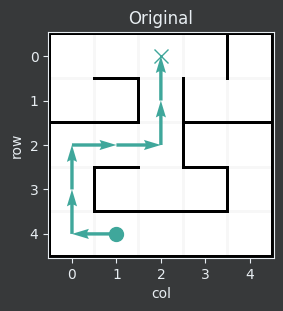

In [158]:
maze_num = 21

example = dataset_left[maze_num].as_tokens(tokenizer) 

prompt, soln = example[: example.index("<PATH_START>") + 1], example[example.index("<PATH_START>") + 1 :]

prediction_original = model.generate(
        "".join(prompt),
        prepend_bos=False,
        max_new_tokens=40,
        do_sample=False
    ) 

plot_maze(prediction_original, tokenizer=tokenizer, ax=gs[0, 0], ax_labels={'maze':{'title': 'Original'}})


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

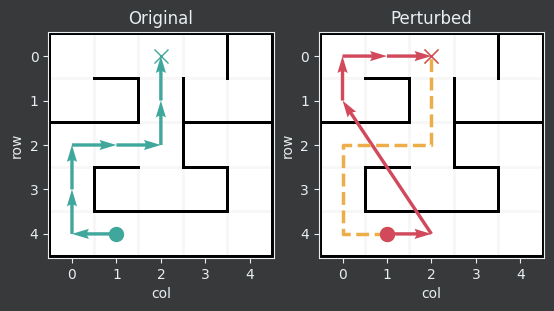

In [167]:
example = dataset_left[maze_num].as_tokens(tokenizer)

apply_act_vecs(act_vec0, 0, 80, example)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

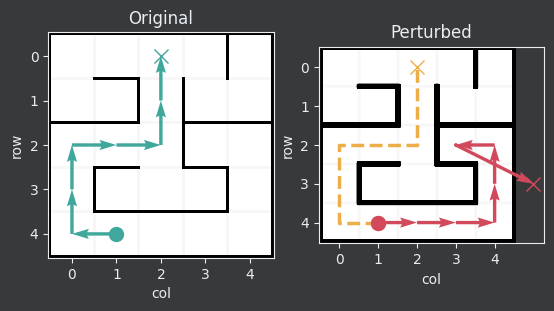

In [160]:
apply_act_vecs(act_vec1, 1, 80, example)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

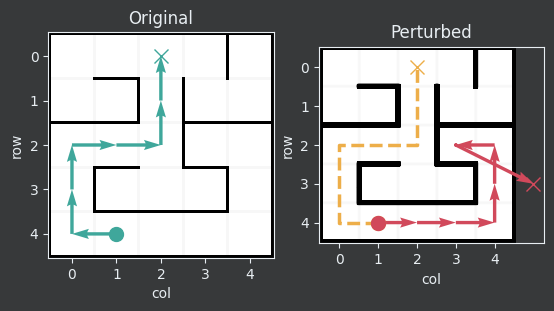

In [161]:
apply_act_vecs(act_vec2, 2, 80, example)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

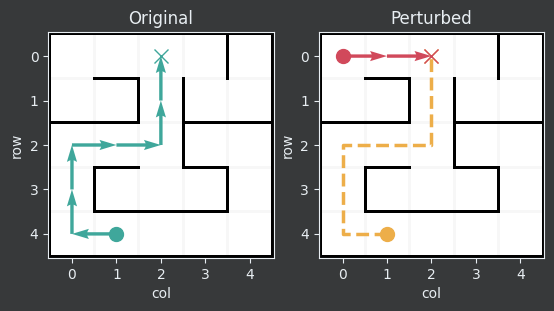

In [162]:
apply_act_vecs(act_vec3, 3, 80, example)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

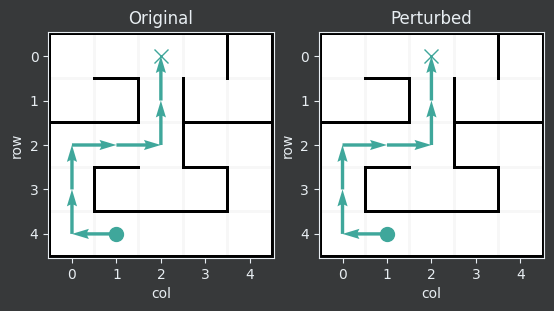

In [163]:
apply_act_vecs(act_vec4, 4, 80, example)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

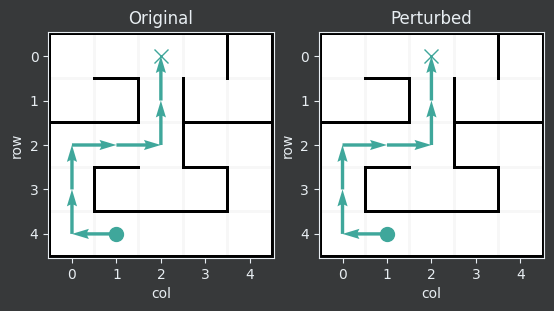

In [164]:
apply_act_vecs(act_vec5, 5, 300, example)